#### Reinforcement Learning, 2024-2025
# Chapter 2 [Barto, Sutton] --- 🎰 K-ARMED BANDIT PROBLEM 

Alviona Mancho | alv.mantso@aueb.gr

## Algorithms

1. $\varepsilon$-greedy 
    
    (for $\varepsilon \geq 0$)
$$
    A_t =
    \begin{cases}
    \arg\max_a Q_t(a), \text{w.p. } 1-{\color{#bc5090}\varepsilon},\\
    \text{chosen uniformly at random, w.p. } {\color{#bc5090}\varepsilon}.
    \end{cases}
$$

2. Upper Confidence Bound (UCB)

$$
    A_t = \arg\max_a \left(Q_t(a) + c \sqrt{\frac{ln(t)}{N_t(a)}}\right), \;\; {\color{#bc5090}c}\in \mathbb{R^{*}_{+}}
$$

3. Stochastic Gradient Ascent (Softmax Preferences)
    1. Set $H_1(a) = 0,\; \forall a\in A$
    2. At time t, select action according to distribution $\pi_t(a) = \frac{e^{H_t(a)}}{\sum_{b\in A} e^ {H_t(b)}}$
    3. After selecting $A_t$ at time t, update:

    $$
        H_{t+1}(A_t) = H_t(A_t) + {\color{#bc5090}\alpha}\cdot(R_t-\bar{R_t})(1-\pi_t(A_t))\\
        H_{t+1}(a) = H_t(A_t) -  {\color{#bc5090}\alpha}\cdot(R_t-\bar{R_t})(\pi_t(a)),\; \forall a \neq A_t
    $$

## Implementation

### Input Arguments

#### Environment Parameters
- **`seed`**: the seed of the random number generator
- **`initial_action_values`**: a row vector with the initial action values, i.e., the mean rewards
- **`real_value_mean`**: the action values are drawn from the normal distribution with mean=`real_value_mean` and std=1
- **`type`**: 
  - `"stationary"`: the action values remain fixed
  - `"nonstationary"`: the action values change by a random step size, drawn from the normal distribution with mean=0 and std=`perturb` at the start of each iteration
- **`perturb`**: the standard deviation for the perturbation in the case of a nonstationary environment
- **`reward_std`**: the standard deviation of the rewards. Rewards are normal with mean equal to action values
- **`iterations`**: number of iterations we execute the strategy

#### Strategy Parameters
- **`strategy`**:
  - `"epsilon-greedy"`: the epsilon-greedy strategy. `epsilon` can be 0 (Section 2.2)
  - `"upper_confidence_bound"`: we use the upper confidence bound method (Section 2.7)
  - `"softmax_preference"`: we soft-max the preferences and use them (Section 2.8)
- **`optimistic`**:
  - `True`: optimistic initial values
  - `False`: realistic initial values
- **`Q_0`**: the optimistic initial value
- **`value_estimate_update_rule`**:
  - `"mean"`: we use the mean reward as an estimate
  - `"exponential_decay"`: we track the reward using exponential decay
- **`epsilon`**: the epsilon parameter for epsilon-greedy strategies
- **`c`**: the parameter of the upper confidence bound strategy
- **`learning_rate_alpha`**: the parameter (learning rate) of the stochastic gradient ascent (softmax preferences)
- **`baseline`**:
  - `True`: `R_bar` is used as the baseline term in stochastic gradient ascent (softmax preferences)
  - `False`: No baseline is used
- **`alpha`**: the parameter used in updating the reward estimate


In [637]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

color = ["#bc5090", "#003f5c", "#ffa600", "#58508d", "#ff6361"]
seed = 42

In [638]:
class Strategy:
    def selected_action(self, params):
        pass
    
class Epsilon_greedy(Strategy):
    def __init__(self, actions, initial_action_vals, reward_std, epsilon):
        self.actions = actions
        self.initial_action_vals = initial_action_vals
        self.reward_std = reward_std
        self.epsilon = epsilon
    
    def select_action(self, params):
        Q = params["Q"]
        max_action_index = np.argmax(Q)
        max_action = self.actions[max_action_index]
        other_actions = self.actions[:max_action_index] + self.actions[max_action_index+1:]
        
        if np.random.random() < self.epsilon:
            selected_action = np.random.choice(other_actions) # chooses uniformly at random
            reward = np.random.normal(self.initial_action_vals[selected_action.id], self.reward_std)
            return selected_action, reward
        else: 
            reward = np.random.normal(self.initial_action_vals[max_action.id], self.reward_std)
            return max_action, reward
        
class Upper_confidence_bound(Strategy):
    def __init__(self, actions, initial_action_vals, reward_std, c):
        self.actions = actions
        self.initial_action_vals = initial_action_vals
        self.reward_std = reward_std
        self.c = c
        self.pi_distribution = None
        self.H = np.zeros(len(actions))
    
    def select_action(self, params):
        Q = params["Q"]
        N = params["N"]
        t = params["t"] 
        
        exploration_term = np.zeros_like(N)  
        exploration_term[N > 0] = self.c * np.sqrt(np.log(t) / N[N > 0])  # only calculate where N > 0
        ucb_values = Q + exploration_term 
        ucb_values[N == 0] = 1000  # if N[a]==0, then a is considered to be a maximizing action

        selected_action = self.actions[np.argmax(ucb_values)]
        reward = np.random.normal(self.initial_action_vals[selected_action.id], self.reward_std)
        return selected_action, reward

class Softmax_preference(Strategy):
    def __init__(self, actions, initial_action_vals, reward_std, learning_rate_alpha):
        self.actions = actions
        self.initial_action_vals = initial_action_vals
        self.reward_std = reward_std
        self.learning_rate_alpha = learning_rate_alpha
        
    def select_action(self, params):
        H = params["H"]
        R_bar = params["R_bar"]
        self.pi_distribution = np.exp(H)/sum(np.exp(H))
        selected_action = np.random.choice(self.actions, p=self.pi_distribution)
        reward = np.random.normal(self.initial_action_vals[selected_action.id], self.reward_std)
        
        H[selected_action.id] = H[selected_action.id] + self.learning_rate_alpha * (reward - R_bar)*(1-self.pi_distribution[selected_action.id])
        for a in self.actions:
            if a != selected_action:
                H[a.id] = H[a.id] - self.learning_rate_alpha * (reward - R_bar)*self.pi_distribution[a.id]
        
        return selected_action, reward    
    
class Action:
    def __init__(self, id, Q_0, step_function):
        self.id = id
        self.sum_of_rewards = 0
        self.num_of_times_selected = 0
        self.Q = Q_0
        self.step_function = step_function
    
    def calculate_estimate(self, new_reward):
        self.sum_of_rewards += new_reward
        self.num_of_times_selected += 1
        self.Q += (self.step_function(self.num_of_times_selected))*(new_reward - self.Q)
        return self.Q

In [689]:
class Experiment:
    @staticmethod
    def conduct_experiment(tasks, env_parameters, strategy_parameters):
        average_reward = np.zeros(env_parameters["iterations"])
        percentage_optimal_action = np.zeros_like(average_reward)
        
        for task in tqdm(range(tasks)):
            # Generate the real values of the actions
            initial_action_vals = list(np.random.normal(env_parameters["real_value_mean"], 1, 10))
            env_parameters["initial_action_vals"] = initial_action_vals
            
            # Start either with realistic or with optimistic initial values
            # For optimistic, w.p. 99.7% the best action will not return a reward greater than the amount specified
            if "Q_0" not in strategy_parameters or strategy_parameters["Q_0"] == None:
                strategy_parameters["Q_0"] = strategy_parameters["optimistic"] * (max(initial_action_vals) + 3*env_parameters["reward_std"]) 
            
            # Run the algorithm for the specified amount of iterations
            rewards, arms_selected, best_arms  = Experiment._multiarmed_bandit(env_parameters, strategy_parameters)
            
            # Average reward
            average_reward += (1/(task+1))*(rewards - average_reward)
            
            # % Optimal action was selected
            binary_arms_selected = (np.array(arms_selected) == np.array(best_arms)).astype(int)
            percentage_optimal_action += (1/(task+1))*(binary_arms_selected - percentage_optimal_action)
        return average_reward, percentage_optimal_action
    
    @staticmethod
    def _multiarmed_bandit(env_parameters, strategy_parameters):
        np.random.seed = env_parameters["seed"]
        
        # Unpack environment parameters
        initial_action_vals = env_parameters["initial_action_vals"]
        reward_std = env_parameters["reward_std"]
        iterations = env_parameters["iterations"] 
        k = env_parameters["num_of_bandits"]

        # Unpack strategy parameters
        alpha = strategy_parameters["alpha"]        # the parameter used in updating the reward estimate
        Q = np.zeros(k) + strategy_parameters["Q_0"]
        
        # Specify whether the values will remain constant across iterations (stationary), or they will undergo random perturbations (non-stationary).
        # In the non-stationary case, the values will change by a random step size, drawn from the normal distribution with mean=0 and std= env_parameters["perturb"]
        value_perturb_function = (lambda x: x + np.random.normal(0, env_parameters["perturb"])) if env_parameters["type"] == "nonstationary" else (lambda x: x)
        
        # Specify the value estimate update rule
        step_function = (lambda k: 1/k) if strategy_parameters["value_estimate_update_rule"] == "mean" else (lambda k: alpha)

        # Generate available actions
        actions = [Action(i, Q[i], step_function) for i in range(k)]    # Q_{k+1} = Q_k + step_function(k)*(R_k - Q_k)
        
        N = np.zeros(k)
        H = np.zeros(k)
        R_bar = 0
        bool_baseline = False # used in stochastic gradient ascent (softmax preferences) to either compare the new reward to a baseline or not
        
        arms_selected = list()
        best_arms = list() # need to track the best arm of each iteration for the nonstationary case
        rewards = list()
        
        # Define the action selection method
        params = None
        strategy_obj = None
        if strategy_parameters["strategy"] == "epsilon_greedy":
            epsilon = strategy_parameters["epsilon"]    # the epsilon parameter for epsilon-greedy strategies
            strategy_obj = Epsilon_greedy(actions, initial_action_vals, reward_std, epsilon)
            params = {"Q": Q}
        elif strategy_parameters["strategy"] == "upper_confidence_bound":
            c = strategy_parameters["c"]                # the parameter of the upper confidence bound strategy
            strategy_obj = Upper_confidence_bound(actions, initial_action_vals, reward_std, c)
            params = {"Q": Q, "N": N, "t": None}
        else:
            learning_rate_alpha  = strategy_parameters["learning_rate_alpha"]
            bool_baseline = strategy_parameters["baseline"]
            strategy_obj = Softmax_preference(actions, initial_action_vals, reward_std, learning_rate_alpha)
            params = {"H": H, "R_bar": None}
            
        for i in range(iterations):
            best_arms.append(np.argmax(initial_action_vals))
            
            t = i+1
            params["t"] = t
            params["R_bar"] = R_bar
            selected_action, reward = strategy_obj.select_action(params)
            
            Q[selected_action.id] = selected_action.calculate_estimate(reward)
            N[selected_action.id] += 1
            R_bar += (step_function(t) * (reward - R_bar))*bool_baseline   # R_bar (baseline term) is either the average or equal to 0
            
            arms_selected.append(selected_action.id)
            rewards.append(reward)
            
            # The values will remain constant across iterations (stationary), or they will undergo random perturbations (non-stationary), 
            # according to the 'value_perturb_function'
            initial_action_vals = [value_perturb_function(x) for x in initial_action_vals]
        
        return rewards, arms_selected, best_arms 

## Experiments

In the following experiments, the performance of various algorithms is evaluated using a set of randomly generated `k`-armed bandit tasks. For each task, the action values ($q(a), a = 1, \dots, 10$), are drawn from a normal (Gaussian) distribution with mean `real_value_mean` and a standard deviation of 1.

At each time step ($t$), for a given bandit, the actual reward ($R_t$) is sampled from a normal distribution with mean ($q(a)$) and standard deviation `reward_std`. Averaging performance across bandits allows us to analyze how the different methods improve as they gain experience over `iterations` steps. The results are visualized to compare the effectiveness and convergence behavior of the algorithms.

### $\varepsilon$-Greedy Action Selection: Comparison of Different $\varepsilon$ Values 
(Replication of figure 2.1)

In [561]:
tasks = 2000
iterations = 2000
k = 10

env_parameters = {"seed": seed,  "real_value_mean": 0, "type":"stationary", "reward_std": 1, "iterations": iterations,  "num_of_bandits": k}
strategy_parameters = {"strategy": "epsilon_greedy", "optimistic": False, "value_estimate_update_rule": "mean", "epsilon": None, "alpha": 0.1}

epsilon_vals = [0, 0.001, 0.01, 0.1, 0.2]
metrics_per_epsilon = list()

for epsilon in epsilon_vals:
    strategy_parameters["epsilon"] = epsilon
    average_reward, percentage_optimal_action = Experiment.conduct_experiment(tasks, env_parameters, strategy_parameters)
    metrics_per_epsilon.append([average_reward, percentage_optimal_action])    

100%|██████████| 2000/2000 [00:33<00:00, 59.18it/s]


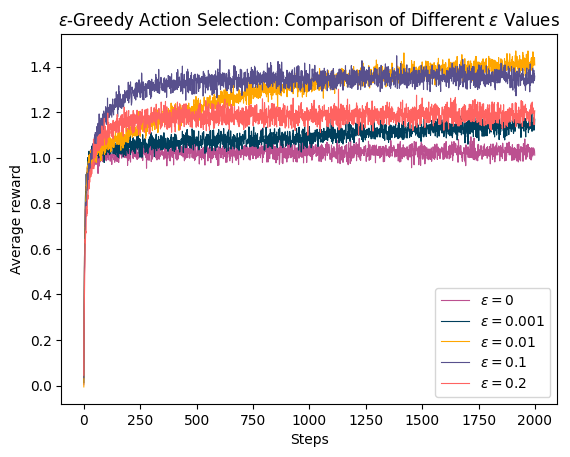

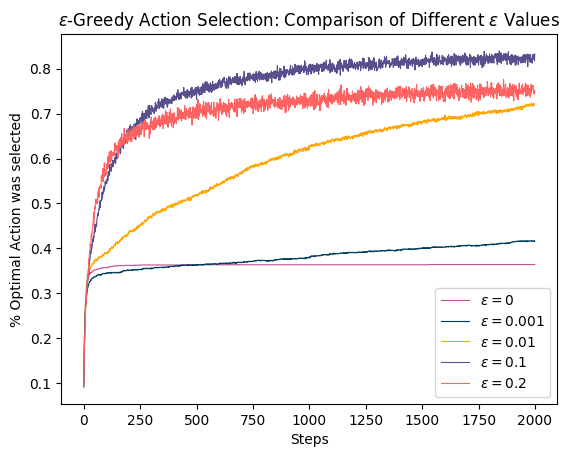

In [562]:
ylabel = ['Average reward', '% Optimal Action was selected']
for j in range(2):
    for i in range(len(epsilon_vals)):
        plt.plot(list(range(iterations)), metrics_per_epsilon[i][j], label=fr'$\varepsilon={epsilon_vals[i]}$', c=color[i], linewidth=0.8)
    plt.title(r'$\varepsilon$-Greedy Action Selection: Comparison of Different $\varepsilon$ Values')
    plt.ylabel(ylabel[j])
    plt.xlabel('Steps')
    plt.legend()
    plt.show()

### Optimistic vs. Realistic Initial Values 
Replication of figure 2.2

In [612]:
tasks = 2000
iterations = 1000
k = 10

metrics_per_experiment = list()

# optimistic, greedy
env_parameters = {"seed": seed, "real_value_mean": 0, "type":"stationary", "reward_std": 1, "iterations": iterations,  "num_of_bandits": k}
strategy_parameters = {"strategy": "epsilon_greedy", "optimistic": True, "Q_0": 5,"value_estimate_update_rule": "exponential_decay", "epsilon": 0, "alpha": 0.1}
average_reward, percentage_optimal_action = Experiment.conduct_experiment(tasks, env_parameters, strategy_parameters)
metrics_per_experiment.append([average_reward, percentage_optimal_action])

# realistic, 0.1-greedy
strategy_parameters["optimistic"] = False
strategy_parameters["Q_0"] = 0
strategy_parameters["epsilon"] = 0.1
average_reward, percentage_optimal_action = Experiment.conduct_experiment(tasks, env_parameters, strategy_parameters)
metrics_per_experiment.append([average_reward, percentage_optimal_action])

# realistic, 0.01-greedy
strategy_parameters["epsilon"] = 0.01
average_reward, percentage_optimal_action = Experiment.conduct_experiment(tasks, env_parameters, strategy_parameters)
metrics_per_experiment.append([average_reward, percentage_optimal_action])

100%|██████████| 2000/2000 [00:10<00:00, 196.36it/s]


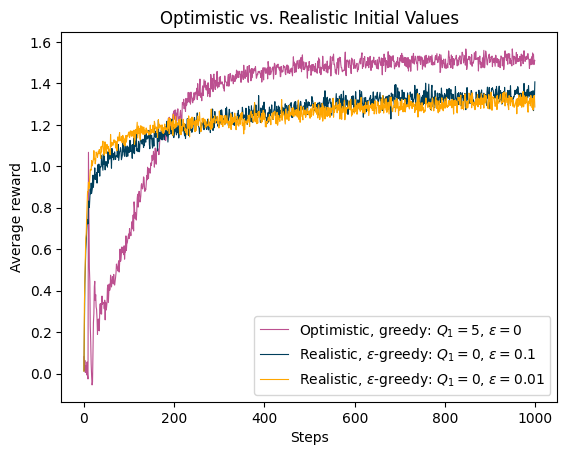

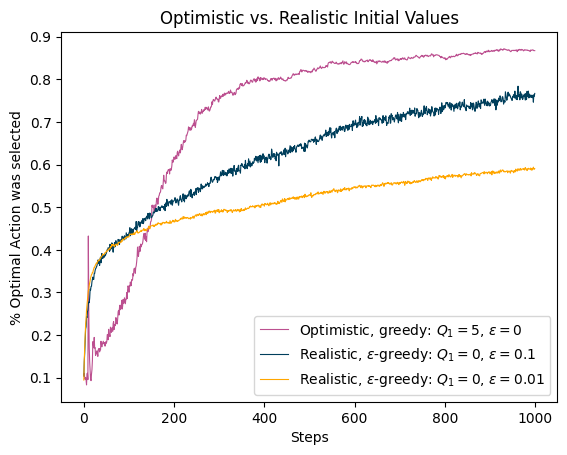

In [613]:
label = [r'Optimistic, greedy: $Q_1 = 5$, $\varepsilon=0$', 
         r'Realistic, $\varepsilon$-greedy: $Q_1 = 0$, $\varepsilon=0.1$',
         r'Realistic, $\varepsilon$-greedy: $Q_1 = 0$, $\varepsilon=0.01$']
ylabel = ['Average reward', '% Optimal Action was selected']
for j in range(2):
    for i in range(len(metrics_per_experiment)):
        plt.plot(list(range(iterations)), metrics_per_experiment[i][j], label=label[i], c=color[i], linewidth=0.8)
    plt.title('Optimistic vs. Realistic Initial Values')
    plt.ylabel(ylabel[j])
    plt.xlabel('Steps')
    plt.legend()
    plt.show()

### UCB Action Selection: Comparison of Different $c$ Values 
Replication of figure 2.3

In [614]:
tasks = 2000
iterations = 1000

env_parameters = {"seed": seed, "type":"stationary", "real_value_mean": 0, "reward_std": 1, "iterations": iterations,  "num_of_bandits": 10}
strategy_parameters = {"strategy": "upper_confidence_bound", "optimistic": False, "value_estimate_update_rule": "mean", "c": None, "alpha": 0.1}

c_vals = [0.5, 1, 2]
metrics_per_experiment = list()

for c in c_vals:
    strategy_parameters["c"] = c
    average_reward, percentage_optimal_action = Experiment.conduct_experiment(tasks, env_parameters, strategy_parameters)
    metrics_per_experiment.append([average_reward, percentage_optimal_action])    

# 0.1-greedy
strategy_parameters["strategy"] = "epsilon_greedy"
strategy_parameters["epsilon"] = 0.1
average_reward, percentage_optimal_action = Experiment.conduct_experiment(tasks, env_parameters, strategy_parameters)
metrics_per_experiment.append([average_reward, percentage_optimal_action])

100%|██████████| 2000/2000 [00:14<00:00, 136.57it/s]


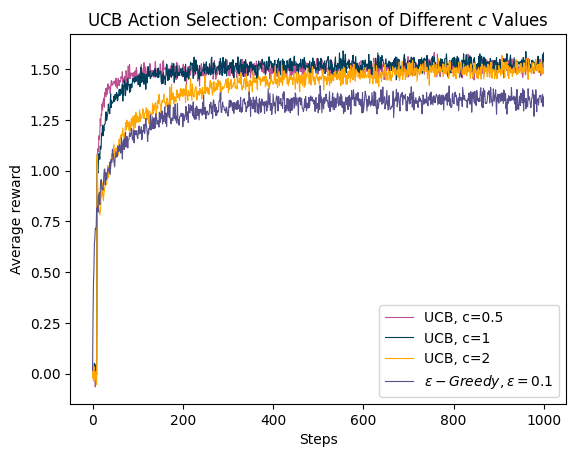

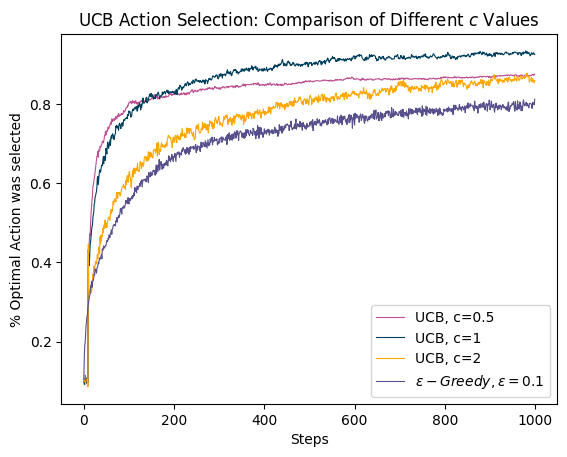

In [615]:
label = [r'UCB, c=0.5', 
         r'UCB, c=1', 
         r'UCB, c=2',
         r'$\varepsilon-Greedy, \varepsilon = 0.1$']
ylabel = ['Average reward', '% Optimal Action was selected']
for j in range(2):
    for i in range(len(metrics_per_experiment)):
        plt.plot(list(range(iterations)), metrics_per_experiment[i][j], label=label[i], c=color[i], linewidth=0.8)
    plt.title(r'UCB Action Selection: Comparison of Different $c$ Values')
    plt.ylabel(ylabel[j])
    plt.xlabel('Steps')
    plt.legend()
    plt.show()

### Stochastic Gradient Ascent: Comparison of Different $\alpha$ Values
Replication of figure 2.4

In [616]:
tasks = 2000
iterations = 1000

env_parameters = {"seed": seed, "real_value_mean": 4, "type":"stationary", "reward_std": 1, "iterations": iterations,  "num_of_bandits": 10}
strategy_parameters = {"strategy": "softmax_preference", "optimistic": False, "value_estimate_update_rule": "mean", "learning_rate_alpha": None, "baseline": None, "alpha": 0.1}

learning_rate_vals = [0.1, 0.4]
baseline_vals = [True, False]
metrics_per_experiment = list()

for a in learning_rate_vals:
    for b in baseline_vals:
        strategy_parameters["learning_rate_alpha"] = a
        strategy_parameters["baseline"] = b
        average_reward, percentage_optimal_action = Experiment.conduct_experiment(tasks, env_parameters, strategy_parameters)
        metrics_per_experiment.append([average_reward, percentage_optimal_action])    

100%|██████████| 2000/2000 [01:08<00:00, 29.19it/s]


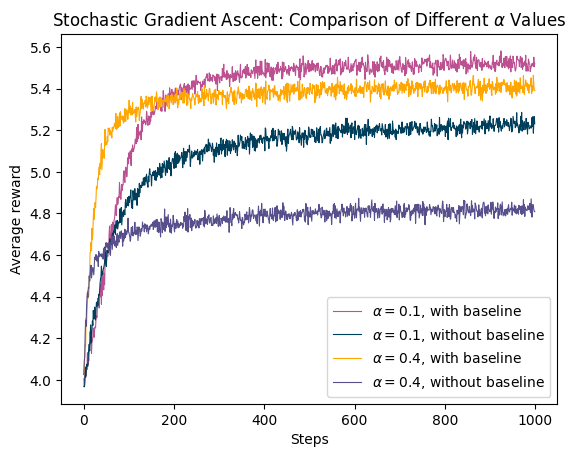

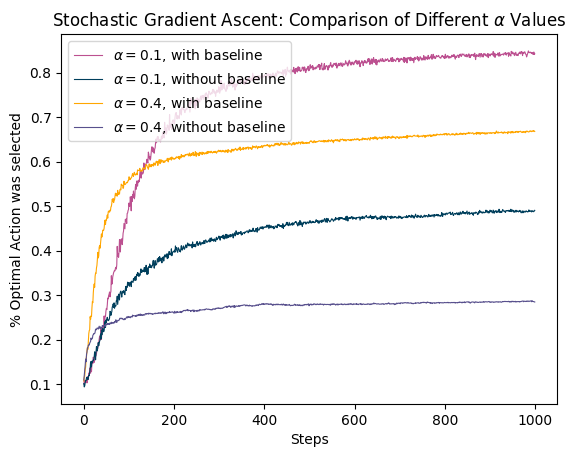

In [617]:
label = [r'$\alpha=0.1$, with baseline', 
         r'$\alpha=0.1$, without baseline', 
         r'$\alpha=0.4$, with baseline', 
         r'$\alpha=0.4$, without baseline', ]
ylabel = ['Average reward', '% Optimal Action was selected']
for j in range(2):
    for i in range(len(metrics_per_experiment)):
        plt.plot(list(range(iterations)), metrics_per_experiment[i][j], label=label[i], c=color[i], linewidth=0.8)
    plt.title(r'Stochastic Gradient Ascent: Comparison of Different $\alpha$ Values')
    plt.ylabel(ylabel[j])
    plt.xlabel('Steps')
    plt.legend()
    plt.show()

### Parameter Study of Various Bandit Algorithms
(Replication of figure 2.5)

In [640]:
tasks = 2000
iterations = 1000

metrics_per_experiment = list()

env_parameters = {"seed": seed,  "real_value_mean": 0, "type": "stationary", "reward_std": 1, "iterations": iterations,  "num_of_bandits": k}
strategy_parameters = {"optimistic": False, "Q_0": 0, "value_estimate_update_rule": "mean", "baseline": True, "alpha": 0.1}


epsilon_vals = [1/(2**i) for i in range(7, 1, -1)]
epsilon_results = list()

learning_rate_vals = [1/(2**i) for i in range(5, -1, -1)] + [2,4]
learning_rate_results = list()

c_vals = [1/(2**i) for i in range(4, -1, -1)] + [2,4]
c_results = list()


strategies = [{"strategy": "epsilon_greedy", "param": "epsilon", "param_vals": epsilon_vals, "param_results": epsilon_results}, 
              {"strategy": "upper_confidence_bound", "param": "c", "param_vals": c_vals, "param_results": c_results},
              {"strategy": "softmax_preference", "param": "learning_rate_alpha", "param_vals": learning_rate_vals, "param_results": learning_rate_results}]

for strategy in strategies:
    strat = strategy["strategy"]
    param = strategy["param"]
    param_vals = strategy["param_vals"]
    param_results = strategy["param_results"]
    
    for param_val in param_vals:
        strategy_parameters["strategy"] = strat
        strategy_parameters[param] = param_val
        average_reward, percentage_optimal_action = Experiment.conduct_experiment(tasks, env_parameters, strategy_parameters)
        single_point_reward = sum(average_reward)/iterations
        param_results.append(single_point_reward)

Q_0_vals = [1/(2**i) for i in range(2, -1, -1)] + [2,4]
Q_0_results = list()

env_parameters = {"seed": seed,  "real_value_mean": 0, "type": "stationary", "reward_std": 1, "iterations": iterations,  "num_of_bandits": k}
strategy_parameters = {"strategy": "epsilon_greedy", "optimistic": True, "value_estimate_update_rule": "exponential_decay", "epsilon": 0, "alpha": 0.1}

for Q_0 in Q_0_vals:
    strategy_parameters["Q_0"] = Q_0
    average_reward, percentage_optimal_action = Experiment.conduct_experiment(tasks, env_parameters, strategy_parameters)
    single_point_reward = sum(average_reward)/iterations
    Q_0_results.append(single_point_reward)

100%|██████████| 2000/2000 [00:10<00:00, 192.52it/s]


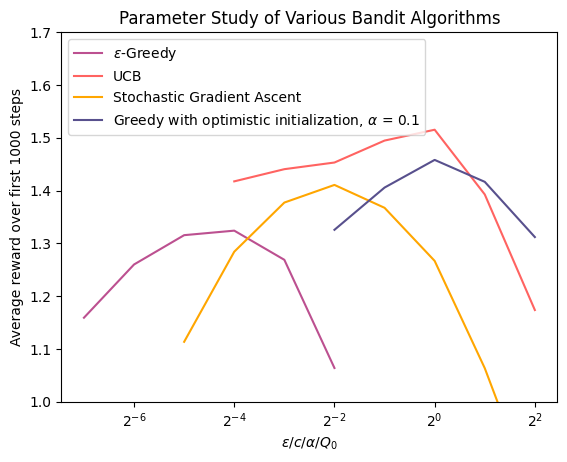

In [629]:
plt.plot(epsilon_vals, epsilon_results, c=color[0], label=r'$\varepsilon$-Greedy')
plt.plot(c_vals, c_results, c=color[4], label=r'UCB')
plt.plot(learning_rate_vals, learning_rate_results, c=color[2], label=r'Stochastic Gradient Ascent')
plt.plot(Q_0_vals, Q_0_results[-5:], c=color[3], label=r'Greedy with optimistic initialization, $\alpha$ = 0.1')

plt.title(r'Parameter Study of Various Bandit Algorithms')
plt.ylabel('Average reward over first 1000 steps')
plt.xlabel(r'$\varepsilon / c / \alpha / Q_0$')
plt.ylim(top=1.7, bottom=1)
plt.xscale('log', base=2)
plt.legend()
plt.show()

### Stationary vs. Nonstationary Version: Comparisons of Various Algorithms

In [671]:
tasks = 2000
iterations = 1000

# Stationary version
env_parameters = {"seed": seed,  "real_value_mean": 0, "type": "stationary", "perturb": 0, "reward_std": 1, "iterations": iterations,  "num_of_bandits": k}
strategy_parameters = {"optimistic": False, "Q_0": 0, "value_estimate_update_rule": "mean", "baseline": True, "alpha": 0.1}

stat_epsilon_results = list()
stat_learning_rate_results = list()
stat_c_results = list()
stat_Q_0_results = list()

strategies = [{"strategy": "epsilon_greedy", "param": "epsilon", "param_val": 0.1, "param_results": stat_epsilon_results}, 
              {"strategy": "upper_confidence_bound", "param": "c", "param_val": 1, "param_results": stat_c_results},
              {"strategy": "softmax_preference", "param": "learning_rate_alpha", "param_val": 0.1, "param_results": stat_learning_rate_results}]

for strategy in strategies:    
    strategy_parameters["strategy"] = strategy["strategy"]
    strategy_parameters[strategy["param"]] = strategy["param_val"]
    average_reward, percentage_optimal_action = Experiment.conduct_experiment(tasks, env_parameters, strategy_parameters)
    strategy["param_results"].extend([average_reward, percentage_optimal_action])
    

strategy_parameters["strategy"] = "epsilon_greedy"
strategy_parameters["epsilon"] = 0
strategy_parameters["value_estimate_update_rule"] = "exponential_decay"
strategy_parameters["optimistic"] = True
strategy_parameters["Q_0"] = 1
average_reward, percentage_optimal_action = Experiment.conduct_experiment(tasks, env_parameters, strategy_parameters)
stat_Q_0_results.extend([average_reward, percentage_optimal_action])

100%|██████████| 2000/2000 [00:18<00:00, 109.41it/s]


In [708]:
# Nonstationary version, with perturb = 0.01
env_parameters = {"seed": seed,  "real_value_mean": 0, "type": "nonstationary", "perturb": 0.01, "reward_std": 1, "iterations": iterations,  "num_of_bandits": k}
strategy_parameters = {"optimistic": False,  "Q_0": 0, "value_estimate_update_rule": "mean", "baseline": True, "alpha": 0.1}

nonstat_epsilon_results = list()
nonstat_learning_rate_results = list()
nonstat_c_results = list()
nonstat_Q_0_results = list()

strategies[0]["param_results"] = nonstat_epsilon_results
strategies[1]["param_results"] = nonstat_c_results
strategies[2]["param_results"] = nonstat_learning_rate_results

for strategy in strategies:    
    strategy_parameters["strategy"] = strategy["strategy"]
    strategy_parameters[strategy["param"]] = strategy["param_val"]
    average_reward, percentage_optimal_action = Experiment.conduct_experiment(tasks, env_parameters, strategy_parameters)
    strategy["param_results"].extend([average_reward, percentage_optimal_action])
    
strategy_parameters["strategy"] = "epsilon_greedy"
strategy_parameters["epsilon"] = 0
strategy_parameters["value_estimate_update_rule"] = "exponential_decay"
strategy_parameters["optimistic"] = True
strategy_parameters["Q_0"] = 1
average_reward, percentage_optimal_action = Experiment.conduct_experiment(tasks, env_parameters, strategy_parameters)
nonstat_Q_0_results.extend([average_reward, percentage_optimal_action])

100%|██████████| 2000/2000 [00:40<00:00, 49.94it/s]


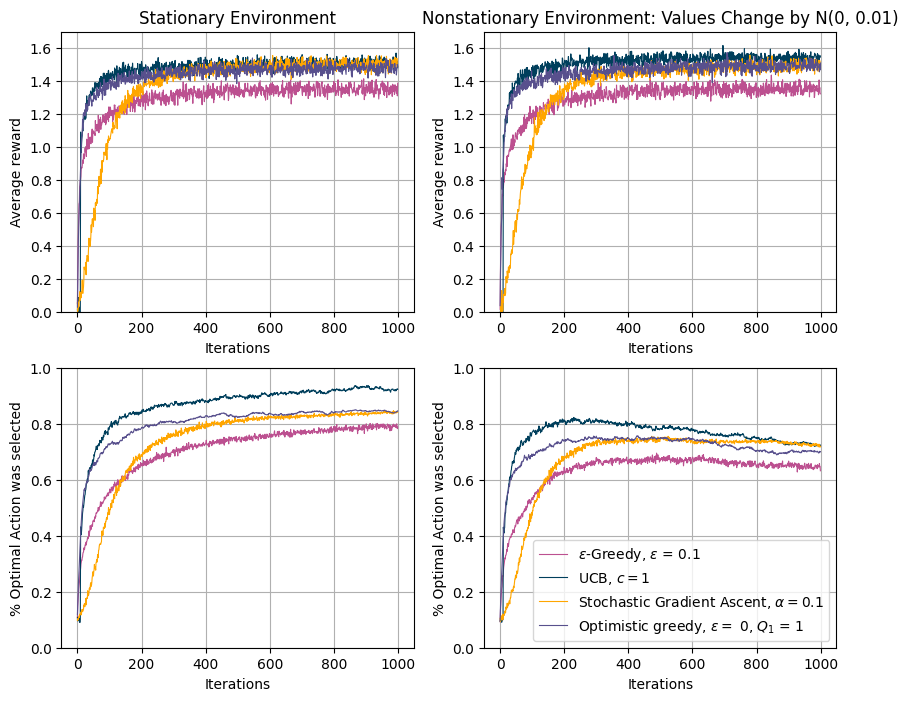

In [710]:
stationary = [stat_epsilon_results, stat_c_results, stat_learning_rate_results, stat_Q_0_results]
nonstationary = [nonstat_epsilon_results, nonstat_c_results, nonstat_learning_rate_results, nonstat_Q_0_results]
stationary_nonstationary = [stationary, nonstationary]

figure, axis = plt.subplots(2, 2, figsize=(10,8))

axis[0, 0].set_title('Stationary Environment')
axis[0, 1].set_title('Nonstationary Environment: Values Change by N(0, 0.01)')

labels = [r'$\varepsilon$-Greedy, $\varepsilon$ = 0.1', r'UCB, $c=1$', r'Stochastic Gradient Ascent, $\alpha = 0.1$', r'Optimistic greedy, $\varepsilon =$ 0, $Q_1$ = 1']
ylabel = ['Average reward', '% Optimal Action was selected']
ylim = [[0, 1.7], [0, 1]]
for version in range(2):
    for metric in range(2):
        for strategy in range(4):
            axis[metric, version].plot(list(range(iterations)), stationary_nonstationary[version][strategy][metric], label=labels[strategy], c=color[strategy], linewidth=0.8)
        axis[metric, version].set_xlabel('Iterations')
        axis[metric, version].set_ylabel(ylabel[metric])
        axis[metric, version].set_ylim(ylim[metric])
        axis[metric, version].grid()
plt.legend()
plt.show()